# Virtual Screening

<div class="alert alert-block alert-info">
<Strong>Objectives</strong>

- Perform virtual screening against PubChem using ligand-based approach
- Apply filters to prioritize virtual screening hit list.
- Learn how to use pandas' data frame.

In this notebook, we perform virtual screening against PubChem using a set of known ligands for muscle glycogen phosphorylase.  Compound filters will be applied to identify drug-like compounds and unique structures in terms of canonical SMILES will be selected to remove redundant structures.  For some top-ranked compounds in the list, their binding mode will be predicted using machine learning (which will be covered in Unit 13: Artificial Intelligence 2: Supervised machine learning).

## 1. Read known ligands from a file.

As a starting point, let's download a set of known ligands against muscle glycogen phosphorylase.  These data are obtained from the DUD-E (Directory of Useful Decoys, Enhanced) data sets (http://dude.docking.org/), which contain known actives and inactives for 102 protein targets.  The DUD-E sets are widely used in benchmarking studies that compare the performance of different virtual screening approaches (https://doi.org/10.1021/jm300687e).

Go to the DUD-E target page (http://dude.docking.org/targets) and find muscle glycogen phosphorylase (Target Name: PYGM, PDB ID: 1c8k) from the target list.  Clicking the target name "PYGM" directs you to the page that lists various files (http://dude.docking.org/targets/pygm).  Download file "**actives_final.ism**", which contains the SMILES strings of known actives.  Rename the file name as "**pygm_1c8k_actives.ism**".  \[Open the file in a text viewer/editor to check the format of this file\].

In [1]:
import pandas as pd

In [2]:
colnames = ['smiles','DUD-E ID', 'CHEMBL_ID']
df_act = pd.read_csv("https://dude.docking.org/targets/pygm/actives_final.ism", sep=" ", names=colnames)
df_act.head(5)

,smiles,DUD-E ID,CHEMBL_ID
0,c1ccc2cc(c(cc2c1)NC(=O)c3cc(ccn3)N(=O)=O)Oc4cc...,220668,CHEMBL134802
1,CC1=C(C(C(=C(N1Cc2ccc(cc2)Cl)C(=O)O)C(=O)O)c3c...,189331,CHEMBL115651
2,CCN1C(=C(C(C(=C1C(=O)O)C(=O)O)c2ccccc2Cl)C(=O)...,188996,CHEMBL113736
3,c1cc(c(c(c1)F)NC(=O)c2cc(ccn2)N(=O)=O)Oc3ccc(c...,219845,CHEMBL133911
4,CC1=C(C(C(=C(N1Cc2cccc(c2)N(=O)=O)C(=O)O)C(=O)...,189034,CHEMBL423509


In [3]:
print(len(df_act))    # Show how many structures are in the "data frame"

77


## 2. Similarity Search against PubChem

Now, let's perform similarity search against PubChem using each known active compound as a query.  There are a few things to mention in this step:

- The isomeric SMILES string is available for each query compound. This string will be used to specify the input structure, so HTTP POST should be used.  (Please review lecture02-structure-inputs.ipynb)

- During PubChem's similarity search, molecular similarity is evaluated using the **PubChem fingerprints** and **Tanimoto** coefficient.  By default, similarity search will return compounds with Tanimoto scores of **0.9 or higher**.  While we will use the default threshold in this practice, it is noteworthy that it is adjustable.  If you use a higher threshold (e.g., 0.99), you will get a fewer hits, which are too similar to the query compounds.  If you use a lower threshold (e.g., 0.88), you will get more hits, but they will include more false positives.

- PubChem's similarity search does **not** return the similarity scores between the query and hit compounds.  Only the hit compound list is returned, which makes it difficult to rank the hit compounds for compound selection.  To address this issue, for each hit compound, we compute **the number of query compounds that returned that compound as a hit.**  \[Because we are using multiple query compounds for similarity search, it is possible for different query compounds to return the same compound as a hit.  That is, the hit compound may be similar to multiple query compounds.  The underlying assumption is that hit compounds returned multiple times from different queries are more likely to be active than those returned only once from a single query.\]

- Add "time.sleep()" to avoid overloading PubChem servers and getting blocked.

In [4]:
smiles_act = df_act.smiles.to_list()

In [5]:
# Note: 
# This code block may take a while to run, as it queries PubChem for each structure.
# It took about 2 minutes in testing

import time
import requests

prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

cids_hit = dict()

for idx, mysmiles in enumerate(smiles_act) :
    
    mydata = { 'smiles' : mysmiles }
    
    url = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt"
    res = requests.post(url, data=mydata)

    if ( res.status_code == 200 ) :
        cids = res.text.split()
        cids = [ int(x) for x in cids ]    # Convert CIDs from string to integer.
    else :
        print("Error at", idx, ":", df_act.loc[idx,'CHEMBL_ID'], mysmiles )
        print(res.status_code)
        print(res.content)
    
    for mycid in cids:
        cids_hit[mycid] = cids_hit.get(mycid, 0) + 1
    
    time.sleep(0.2)

In [6]:
len(cids_hit)    # Show the number of compounds returned from any query.

28526

In the above code cells, the returned hits are stored in a dictionary, along with the number of times they are returned.  Let's print the top 10 compounds that are returned the most number of times from the search.

In [7]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :

    if v == 10 : 
        break
    
    print(v, k) # Print (frequency, CID)
    

0 (16, 44354348)
1 (15, 44354370)
2 (15, 44354349)
3 (15, 44354322)
4 (13, 44357907)
5 (12, 44357938)
6 (12, 44357937)
7 (12, 44354455)
8 (12, 44354454)
9 (12, 44354362)


## 3. Exclude the query compounds from the hits

In the previous step, we repeated similarity searches using multiple query molecules.  This may result in a query molecule being returned as a hit from similarity search using another query molecule.  Therefore, we want to check if the hit compound list has any query compounds and if any, we want to remove them.  Below, we search PubChem for compounds identical to the query molecules and remove them from the hit compound list.<p>
Note that the identity_type parameter in the PUG-REST request is set to "**same_connectivity**", which will return compounds with the same connectivity with the query molecule (ignoring stereochemistry and isotope information).  The default for this parameter is "same_stereo_isotope", which returns compounds with the same stereochemistry AND isotope information.

In [8]:
# This code cell make take some time to run, as it queries PubChem for each structure.
# It took about 1 minute in testing

cids_query = dict()

for idx, mysmiles in enumerate(smiles_act) :
    
    mydata = { 'smiles' : mysmiles }
    url = prolog + "/compound/fastidentity/smiles/cids/txt?identity_type=same_connectivity"
    res = requests.post(url, data=mydata)

    if ( res.status_code == 200 ) :
        cids = res.text.split()
        cids = [ int(x) for x in cids]
    else :
        print("Error at", idx, ":", df_act.loc[idx,'id'], mysmiles )
        print(res.status_code)
        print(res.content)
       
    for mycid in cids:
        cids_query[mycid] = cids_query.get(mycid, 0) + 1
    
    time.sleep(0.2)

In [9]:
len(cids_query.keys())    # Show the number of CIDs that represent the query compounds.

138

Now remove the query compounds from the hit list (if they are found in the list)

In [10]:
for mycid in cids_query.keys() :
    
    cids_hit.pop(mycid, None)

In [11]:
len(cids_hit)

28388

Print the top 10 compounds in the current hit list and compare them with the old ones.

In [12]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :
    
    if v == 10 : 
        break
    
    print(v, k)    # Print (frequency, CID)


0 (12, 11779854)
1 (11, 168140615)
2 (11, 166196489)
3 (11, 141135915)
4 (11, 118078858)
5 (11, 93077065)
6 (11, 93077064)
7 (11, 53013349)
8 (11, 51808718)
9 (11, 45369696)


<div class="alert alert-block alert-warning">
<Strong>Check Your Understanding</strong>

- How many molecules were returned from the original query?
- How many molecules were returned were the query compounds?
- Does the number of molecules in len(cids_hits) confirm you have removed the query compounds from the original list?
- Have the top 10 compounds in hit list changed? Does this confirm you have removed the query compounds from the original list?

## 4. Filtering out non-drug-like compounds

We want to identify problematic compounds to exclude from virtual screening. These are molecules that are not absorbed well and may not be good for an orally administered drug. 

A team at Pfizer led by Christopher Lipinski evaluated 2245 compounds that reached phase II clinical trials and determined most orally administered drugs are relatively small and moderately lipophilic. This lead to the <a href ="https://pubmed.ncbi.nlm.nih.gov/11259830/">"Rule of 5" for "drug-likeness"</a> and helps determine whether a molecule has good solubility and permeability. The team suggests that a good lead follow has characteristics based on the number 5:

- Molecular weight < 500
- no more than 5 hydrogen bond donors
- no more than 10 hydrogen bond acceptors
- a calculated octanol-water partician coefficent (XLogP) <5

In this step, non-drug-like compounds are filtered out from the list using these criteria.  To do that, these four molecular properties are downloaded from PubChem and stored in CSV.

In [13]:
# This code cell may take a while to run, as it queries PubChem for each structure.
# It took about 4 minutes in testing
chunk_size = 100

if ( len(cids_hit) % chunk_size == 0 ) :
    num_chunks = len(cids_hit) // chunk_size 
else :
    num_chunks = len(cids_hit) // chunk_size + 1

cids_list = list(cids_hit.keys())
    
print("# Number of chunks:", num_chunks )

csv = ""   #sets a variable called csv to save the comma separated output

for i in range(num_chunks) :
    
    print(i, end=" ")
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)

    cids_str = ",".join([ str(x) for x in cids_list[idx1:idx2] ]) # build pug input for chunks of data
    url = prolog + "/compound/cid/" + cids_str + "/property/HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES/csv"
    
    res = requests.get(url)
    
    if ( i == 0 ) : # if this is the first request, store result in empty csv variable
        csv = res.text 
    else :          # if this is a subsequent request, add the request to the csv variable adding a new line between chunks
        csv = csv + "\n".join(res.text.split()[1:]) + "\n" 
      
    time.sleep(0.2)

# print(csv)

# Number of chunks: 284
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 27

Downloaded data (in CSV) are loaded into a pandas data frame.

In [14]:
from io import StringIO

csv_file = StringIO(csv)

df_raw = pd.read_csv(csv_file, sep=",")

df_raw.shape    # Show the shape (dimension) of the data frame

(28388, 7)

In [15]:
df_raw.head(5)    # Show the first 5 rows of the data frame

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES
0,1731763,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...
1,21795259,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...
2,155906259,0,5,439.9,6.3,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...
3,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...
4,9823695,3,4,424.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...


Note that some compounds do not have computed XLogP values (because XLogP algorithm cannot handle inorganic compounds, salts, and mixtures) and we want to remove them.

In [16]:
df_raw.isna().sum()    # Check if there are any NULL values.

CID                     0
HBondDonorCount         0
HBondAcceptorCount      0
MolecularWeight         0
XLogP                 926
ConnectivitySMILES      0
SMILES                  0
dtype: int64

In [17]:
len(df_raw)    # Check the number of rows (which is equals to the number of CIDs)

28388

For convenience, add the information contained in the **cids_hit** dictionary to this data frame

In [18]:
# First load the cids_hit dictionary into a data frame.
df_freq = pd.DataFrame( cids_hit.items(), columns=['CID','HitFreq'])
df_freq.head(5)

,CID,HitFreq
0,1731763,2
1,21795259,4
2,155906259,4
3,9910160,3
4,9823695,3


In [19]:
# Double-check if the data are loaded correctly
# Compare the data with those from Cell [12]
df_freq.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)

,CID,HitFreq
840,11779854,12
1921,168140615,11
3700,166196489,11
1658,141135915,11
1489,118078858,11
3176,93077065,11
3175,93077064,11
1011,53013349,11
2562,51808718,11
2363,45369696,11


In [20]:
# Create a new data frame called "df" by joining the df and df_freq data frames
df = df_raw.join(df_freq.set_index('CID'), on='CID')
df.shape

(28388, 8)

In [21]:
df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES,HitFreq
840,11779854,3,2,305.3,2.6,C1C(C(=O)NC2=CC=CC=C21)NC(=O)C3=CC4=CC=CC=C4N3,C1C(C(=O)NC2=CC=CC=C21)NC(=O)C3=CC4=CC=CC=C4N3,12
1921,168140615,3,2,319.4,3.0,CC1=C2C(=CC=C1)C=C(N2)C(=O)NC3CC4=CC=CC=C4NC3=O,CC1=C2C(=CC=C1)C=C(N2)C(=O)NC3CC4=CC=CC=C4NC3=O,11
3700,166196489,2,3,390.5,3.0,CN1CCN(CC1CC2=CC=CC=C2)C(=O)CNC(=O)C3=CC4=CC=C...,CN1CCN(CC1CC2=CC=CC=C2)C(=O)CNC(=O)C3=CC4=CC=C...,11
1658,141135915,1,1,290.4,4.2,CC1CCC2=CC=CC=C2N1C(=O)C3=CC4=CC=CC=C4N3,CC1CCC2=CC=CC=C2N1C(=O)C3=CC4=CC=CC=C4N3,11
1489,118078858,1,2,333.4,3.0,CC1CN(C2=CC=CC=C2N1C(=O)C)C(=O)C3=CC4=CC=CC=C4N3,C[C@H]1CN(C2=CC=CC=C2N1C(=O)C)C(=O)C3=CC4=CC=C...,11
3176,93077065,2,2,409.5,4.8,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,C1CC2=CC=CC=C2N(C1)C(=O)[C@@H](C3=CC=CC=C3)NC(...,11
3175,93077064,2,2,409.5,4.8,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,C1CC2=CC=CC=C2N(C1)C(=O)[C@H](C3=CC=CC=C3)NC(=...,11
1011,53013349,2,2,409.5,4.8,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,11
2562,51808718,2,3,390.5,2.9,CC(C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC4=CC...,C[C@H](C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC...,11
2363,45369696,2,3,390.5,2.9,CC(C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC4=CC...,CC(C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC4=CC...,11




Now identify and remove those compounds that satisfy all criteria of Lipinski's rule of five.

In [22]:
len(df[ df['HBondDonorCount'] <= 5 ])

28308

In [23]:
len(df[ df['HBondAcceptorCount'] <= 10 ])

28370

In [24]:
len(df[ df['MolecularWeight'] <= 500 ])

27396

In [25]:
len(df[ df['XLogP'] < 5 ])

24543

In [26]:
df = df[ ( df['HBondDonorCount'] <= 5) &
         ( df['HBondAcceptorCount'] <= 10 ) &
         ( df['MolecularWeight'] <= 500 ) &
         ( df['XLogP'] < 5 ) ]

In [27]:
len(df)

24043

In [28]:
df.isna().sum()    # Check if there are any NULL values.

CID                   0
HBondDonorCount       0
HBondAcceptorCount    0
MolecularWeight       0
XLogP                 0
ConnectivitySMILES    0
SMILES                0
HitFreq               0
dtype: int64

<div class="alert alert-block alert-warning">
<Strong>Check Your Understanding</strong>

- How many molecules were in the raw dataset of molecules that had Tanimoto Similarity of 0.9?
- How many molecules were removed because they didn't follow the Rule of 5?
- How were null values treated in the applying the Rule of 5?

## 5. Draw the structures of the top 10 compounds

Let's check the structure of the top 10 compounds in the hit list.

In [29]:
cids_top = df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()

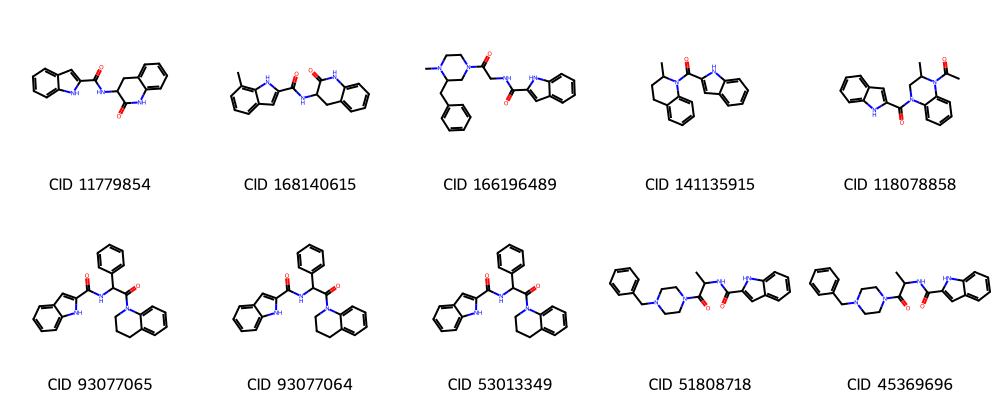

In [31]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].ConnectivitySMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=mylegends)
display(img)

An important observation from these images is that the hit list contains multiple compounds with the same connectivity.  For example, CIDs 93077065 and 93077064 are stereoisomers of each other and CID 53013349 has the same connectivity as the two CIDs, but with its stereocenter being unspecified. When performing a screening with limited resources in the early stage of drug discovery, you may want to test as diverse molecules as possible, avoiding testing too similar structures.

To do so, let's look into PubChem's canonical SMILES strings, which do not encode the stereochemisry and isotope information.  Chemicals with the same connectivity but with different stereochemistry/isotopes should have the same canonical SMILES.  In the next section, we select unique compounds in terms of canonical SMILES to reduce the number of compounds to screen.

## 6. Extract unique compounds in terms of canonical SMILES

The next few cells show how to get unique values within a column (in this case, unique canonical SMILES).

In [32]:
# Show the number of rows in the data frame
len(df) 

24043

In [34]:
# Show the number of unique structures in the data frame
len(df.ConnectivitySMILES.unique()) 

19112

In [44]:
# Get unique structures
canonical_smiles = df.ConnectivitySMILES.unique() 

In [47]:
# Show all the entries for the first unique structure
df[ df.ConnectivitySMILES == canonical_smiles[0] ] 

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES,HitFreq
3,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3
15,70155849,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3


In [49]:
# Show all the entries for the second unique structure
df[ df.ConnectivitySMILES == canonical_smiles[1] ] 

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES,HitFreq
4,9823695,3,4,424.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3


In [52]:
# Show all the stereoisomers for the first unique structure
df[ df.ConnectivitySMILES == canonical_smiles[0] ].SMILES.to_list() 


['CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)NC/C=C/C3=CC=CC=C3',
 'CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)NCC=CC3=CC=CC=C3']

Now let's generate a list of unique compounds in terms of canonical SMILES.  If multiple compounds have the same canonical SMILES, the one that appears very first will be included in the unique compound list.

In [54]:
idx_to_include = []

for mysmiles in canonical_smiles :

    myidx = df[ df.ConnectivitySMILES == mysmiles ].index.to_list()[0]
    
    idx_to_include.append( myidx )

In [55]:
len(idx_to_include)

19112

In [56]:
# Create a new column 'Include' 
# All values initialized to 0 (not include)
df['Include'] = 0 
print(df['Include'].sum()) # Show the total number of included compounds, should be 0 now

0


In [57]:
# Now the "Include" column's value is modified if the record is in the idx_to_include list.
df.loc[idx_to_include,'Include'] = 1 # Set "Include" to 1 for the selected records
print(df['Include'].sum()) # Show the total number of included compounds, should be equal to the number of unique structures

19112


In [58]:
df[['CID','Include']].head(15) # Show the first 15 rows of the "CID" and "Include" columns


,CID,Include
3,9910160,1
4,9823695,1
5,15838575,1
6,15838576,1
7,18318270,1
8,18318274,1
10,18318313,1
11,18318317,1
12,20183492,1
13,70073800,0


Now draw the top 10 unique compounds (in terms of canonical SMILES). Note the, the structure figures are drawn using isomeric SMILES, but canonical SMILES strings could be used.

In [59]:
cids_top = df[ df['Include'] == 1].sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()
print(cids_top)

[11779854, 168140615, 166196489, 141135915, 118078858, 53013349, 17600716, 131851009, 110098384, 110098233]


In [60]:
mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].IsomericSMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=mylegends)
display(img)

AttributeError: 'DataFrame' object has no attribute 'IsomericSMILES'

<div class="alert alert-block alert-warning">
<Strong>Check Your Understanding</strong>

- Recall from cell [46] that row 15 CID 70155849 is an isomer of row 3. In Cell [55] how do you know this was excluded because it was an isomer?

- Previously we showed CIDs 93077065 and 93077064 are stereoisomers of each other and CID 53013349 has the same connectivity as the two CIDs, but with its stereocenter being unspecified. All three were in our original display of the top 10 unique molecules. Which of these are in our new list?

## 7. Saving molecules in files

Now save the molecules in the cids_top list in files, which will be used in molecular docking experiments.  For simplicity, we will use only the **top 3** compounds in the list.

In [62]:
from rdkit.Chem import AllChem

for idx, mycid in enumerate( cids_top ) :

    if idx == 3 :
        break
        
    mysmiles = df[ df['CID'] == mycid ].SMILES.item()

    mymol = Chem.MolFromSmiles(mysmiles)
    mymol = Chem.AddHs(mymol)
    AllChem.EmbedMolecule(mymol)
    AllChem.MMFFOptimizeMolecule(mymol)

    filename = "pygm_lig" + str(idx) + "_" + str(mycid) + ".mol"
    Chem.MolToMolFile(mymol, filename)


To save all data in the **df** data frame (in CSV) 

In [63]:
df.to_csv('pygm_df.csv')

<div class="alert alert-block alert-success">
<center><H1>Homework</H1></center>

In this activity you used filtered by Lipinski's Rule of Five(Ro5) and saved those molecules in pygm_df.csv. The Ro5 focuses on drug-likeness helping to identify favorable properties for oral bioavailability which is important in the later stages of the drug development pipeline. 

If we are interested in creating a list of molecues that are potentially interesting in the early phases of drug discovery, there is another set of rules that emphasizes "lead-likeness". Leads are molecules that serve as a starting point modify and create drugs for testing. 

Miles Congreve proposed the <a href="https://pubmed.ncbi.nlm.nih.gov/14554012/">"Rule of 3"</a> to create a list of lead like filters rather than drug like filters. 

Congreve’s rule of 3
- The number of hydrogen bond donors ≤3
- The number of hydrogen bond acceptors ≤ 3
- Molecular weight < 300
- XlogP ≤ 3

#### Step 1
Load the actives_final.ism for cyclooxygenase-2 (Target Name: PGH2, PDB ID: 3ln1) from the DUD-E database into a pandas DataFrame called df_COX2_act. After loading the data, show the following information:

- the number of rows of the data frame
- the first five rows of the data frame

In [ ]:
# Write your code here

#### Step 2 
Perform similarity search using each of the isomeric SMILES contained in the loaded data frame.

- As we did for PYGM ligands in this notebook, track the number of times a particular hit is returned from multiple queries, using a dictionary named cids_hit (CIDs as keys and the frequencies as values). This information will be used to rank the hit compounds.
- Make sure that the CIDs are recognized as integers when they are used as keys in the dictionary.
- Print the total number of hits returned from this step (which is the same as the number of CIDs in **cids_hit**).
- Add time.sleep() to avoid overloading PubChem servers.

In [ ]:
# Write your code here

#### Step 3
The hit list from the above step may contain the query compounds themselves. Get the CIDs of the query compounds through idenitity search and remove them from the hit list.

- Set the optional parameter "identity_type" to "same_connectivity".
- Add time.sleep() to avoid overloading PubChem servers.
- Print the number of CIDs corresponding to the query compounds.
- Print the number of the remaining hit compounds, after removing the query compounds from the hit list.

In [ ]:
# Write your code here

#### Step 4
Download the hydrogen donor and acceptor counts, molecular weights, XlogP, and canonical and isomeric SMILES for each compound in cids_hit. Load the downloaded data into a new data frame called df_COX2_raw. Print the size (or dimension) of the data frame using .shape.

In [ ]:
# Write your code here

#### Step 5
Create a new data frame called df_COX2_combined, which combines the data stored in cids_hit and df_COX2_raw.

- First load the frequency data into a new data frame called df_COX2_freq
- Join df_COX2_raw and df_COX2_freq into df_COX2_combined
- Print the shape (dimension) of df_COX2_combined

In [ ]:
# Write your code here

#### Step 6
Remove from df_COX2_combined **all** compounds that violate **any** criterion of Congreve's rule of 3 and show the number of remaining compounds.

In [ ]:
# Write your code here

#### Step 7
Get the unique canonical SMILES strings from the df_COX2_combined. Add to df_COX2_combined a column named 'Include', which contains a flag set to 1 for the lowest CID associated with each unique CID and set to 0 for other CIDs. Show the number of compounds for which this flag is set to 1.

In [ ]:
# Write your code here

#### Step 8
Among those with the "Include" flag set to 1, identify the top 10 compounds that were returned from the largest number of query compounds.

- Sort the data frame by the number of times returned (in descending order) and then by CID (in ascending order)
- For each of the 10 compounds, print its CID, isomeric SMILES, and the number of times it was returned.
- For each of the 10 compounds, draw its structure (using isomeric SMILES).




In [ ]:
# Write your code here

#### Step 9
Now save the **top 3** compounds with CID and Isomeric SMILES in a file called COX2_congreve.csv. 

In [ ]:
# Write your code here